In [1]:
from FFlowUtils.dataloading import load_sales, DATA_FOLDER

import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sales = load_sales()
sales.head()

(939, 8)


,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
0,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
2,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
4,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.64,0.99,0.0,13.0,12.84
6,2022-02-08,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,10.0,14.0,20.71
8,2022-02-08,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,9.89


# Preprocessing

Resample by item_name and day. Since I don't have too much information, I will go for a basic train/validation split to assess the goodness of fit of the models even though I know that the production model will be used for next day only.

In [3]:
df_sales = sales.set_index('day').groupby('item_name').apply(lambda x: x.resample('d').sum())
df_sales.reset_index(inplace=True)
df_sales['split'] = np.where(df_sales.day>'2021-12-31', 'validation', 'train')

df_sales.head()

/tmp/ipykernel_47584/3301422253.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sales = sales.set_index('day').groupby('item_name').apply(lambda x: x.resample('d').sum())


,item_name,day,item_number,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,split
0,ROMA TOMATEN ES I 500G SF,2021-04-03,80317483,0.978451,1.546338,40.0,17.0,25.33,train
1,ROMA TOMATEN ES I 500G SF,2021-04-04,80317483,0.978451,1.546338,0.0,0.0,0.00,train
2,ROMA TOMATEN ES I 500G SF,2021-04-05,80317483,0.978451,1.546338,0.0,0.0,0.00,train
3,ROMA TOMATEN ES I 500G SF,2021-04-06,80317483,0.990000,1.490000,0.0,18.0,26.82,train
4,ROMA TOMATEN ES I 500G SF,2021-04-07,80317483,0.990000,1.490000,10.0,5.0,7.45,train


In [4]:
df_sales.day.max() - df_sales.day.min()

Timedelta('312 days 00:00:00')

# Naive model

We should never neglect the power that a simple model can yield. Here, I am going to select last week sales.

In [20]:
# we dont have leap year, so just go for 365 days ago
df_sales['prediction'] = df_sales.groupby('item_name').sales_quantity.transform(lambda x: x.shift(7))
df_sales.head()

,item_name,day,item_number,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,split,prediction
0,ROMA TOMATEN ES I 500G SF,2021-04-03,80317483,0.978451,1.546338,40.0,17.0,25.33,train,NaN
1,ROMA TOMATEN ES I 500G SF,2021-04-04,80317483,0.978451,1.546338,0.0,0.0,0.00,train,NaN
2,ROMA TOMATEN ES I 500G SF,2021-04-05,80317483,0.978451,1.546338,0.0,0.0,0.00,train,NaN
3,ROMA TOMATEN ES I 500G SF,2021-04-06,80317483,0.990000,1.490000,0.0,18.0,26.82,train,NaN
4,ROMA TOMATEN ES I 500G SF,2021-04-07,80317483,0.990000,1.490000,10.0,5.0,7.45,train,NaN


In [6]:
df_sales[df_sales.item_name=='ROMA TOMATEN ES I 500G SF'].head(10)

,item_name,day,item_number,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,split,prediction
0,ROMA TOMATEN ES I 500G SF,2021-04-03,80317483,0.978451,1.546338,40.0,17.0,25.33,train,NaN
1,ROMA TOMATEN ES I 500G SF,2021-04-04,80317483,0.978451,1.546338,0.0,0.0,0.00,train,NaN
2,ROMA TOMATEN ES I 500G SF,2021-04-05,80317483,0.978451,1.546338,0.0,0.0,0.00,train,NaN
3,ROMA TOMATEN ES I 500G SF,2021-04-06,80317483,0.990000,1.490000,0.0,18.0,26.82,train,NaN
4,ROMA TOMATEN ES I 500G SF,2021-04-07,80317483,0.990000,1.490000,10.0,5.0,7.45,train,NaN
5,ROMA TOMATEN ES I 500G SF,2021-04-08,80317483,0.990000,1.490000,20.0,16.0,23.54,train,NaN
6,ROMA TOMATEN ES I 500G SF,2021-04-09,80317483,0.990000,1.490000,0.0,19.0,28.31,train,NaN
7,ROMA TOMATEN ES I 500G SF,2021-04-10,80317483,0.990000,1.490000,20.0,13.0,19.22,train,17.0
8,ROMA TOMATEN ES I 500G SF,2021-04-11,80317483,0.978451,1.546338,0.0,0.0,0.00,train,0.0
9,ROMA TOMATEN ES I 500G SF,2021-04-12,80317483,0.990000,1.490000,20.0,9.0,13.41,train,0.0


In [8]:
# check very simple model validation error
val_df = df_sales[df_sales.split=='validation']
mean_absolute_error(val_df.sales_quantity, val_df.prediction)

5.341666666666667

# Auto-arima by item name

Due to the time constraint, I will use an auto arima model, similar to the one in the fantastic R package forecasting. This allows me to streamline the modeling process.

In [9]:
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def plot_autocorrelations(series, lags):
    """
    It takes a time series and a list of lags, and plots the autocorrelation function and partial
    autocorrelation function for the time series
    
    Args:
      series: The series to plot the autocorrelations for.
      lags: The number of lags to include in the plot.
    """
    fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
    
    plot_acf(series, lags=lags, ax=ax[0])
    ax[0].set_title('ACF Plot')
    ax[0].grid(linewidth=0.5)
    plot_pacf(series, lags=lags, ax=ax[1])
    ax[1].set_title('Partial ACF Plot')
    ax[1].grid(linewidth=0.5)
    return ax

In [12]:
train_df = df_sales[df_sales.split=='train']
val_df = df_sales[df_sales.split=='validation']

Before selecting the model, however, we need to establish the seasonality:

ACF and PACF for item ROMA TOMATEN ES I 500G SF


/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


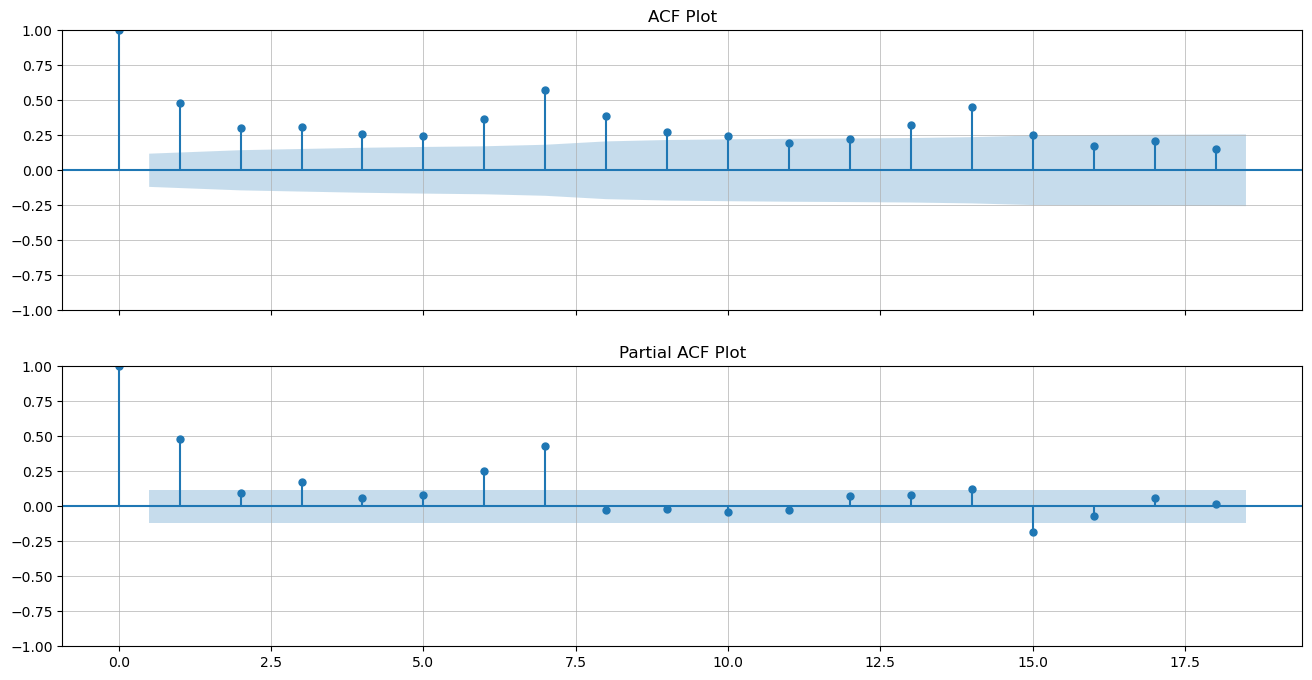

ACF and PACF for item SL MANDARINEN BEH.ES I 750G GS


/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


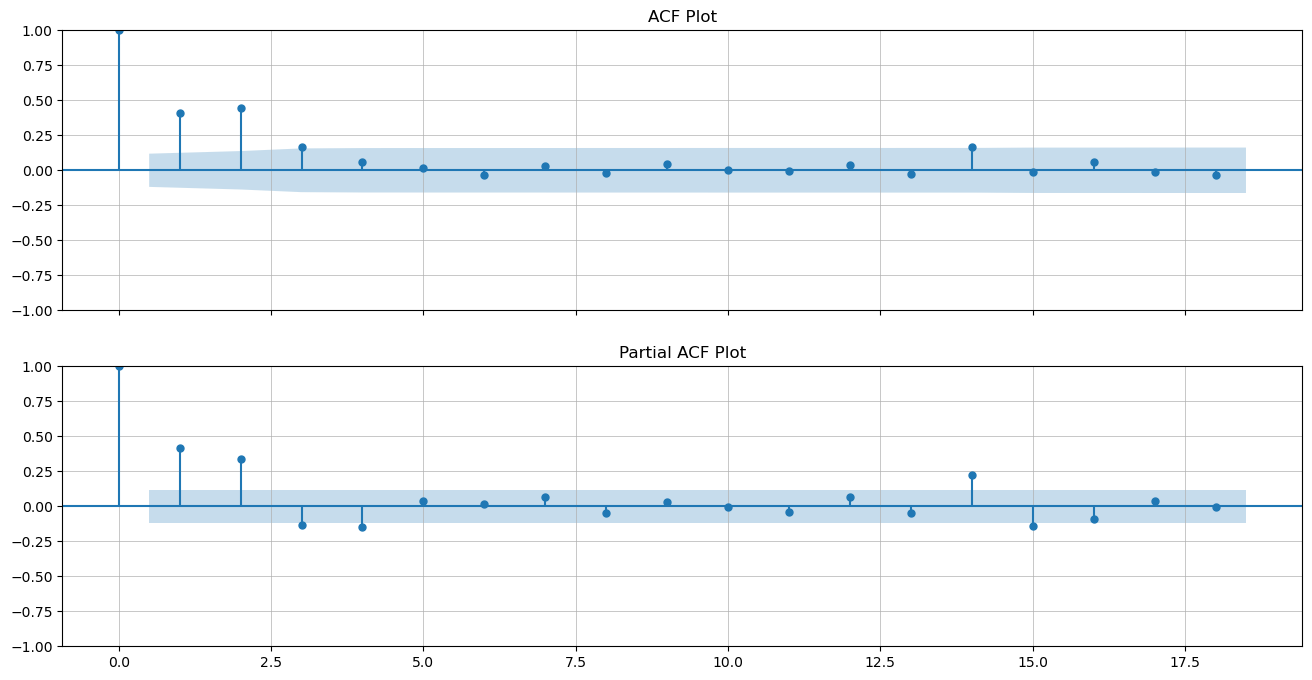

ACF and PACF for item UH ZWIEBELN DE-HE I 1KG GS


/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


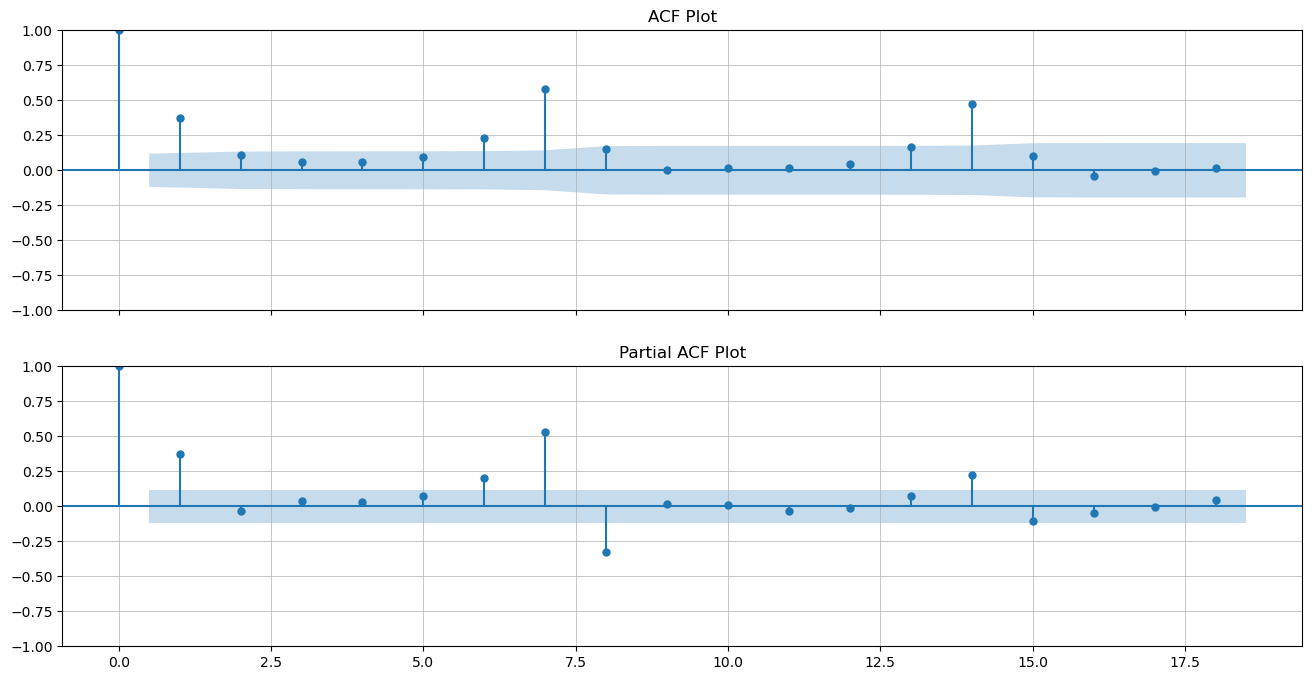

In [13]:
item_list = list(df_sales.item_name.unique())

for item in item_list:
    itemTrain_df = train_df[train_df.item_name==item]
    itemVal_df = val_df[val_df.item_name==item]
    print('ACF and PACF for item %s' %item)
    plot_autocorrelations(itemTrain_df.set_index('day').sales_quantity, lags=18)
    plt.show()

From these plots, a daily seasonality looks fine for onions and tomatoes look good. Our autorregressive and moving average components might be good enough at just one lag value, based on the way the autocorrelation drops. The day of week seasonality should be well fitted by this model using m=7, with seasonal=True when we are dealing with onions and tomatoes

In [16]:
weekly_model = auto_arima(itemTrain_df.set_index('day').sales_quantity,
                    start_p=1,
                    start_q=1,
                    max_p=3,
                    max_q=3, 
                    m=7,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='trace',  
                    suppress_warnings=True, 
                    stepwise=True)


weekly_model.summary()

n_periods = itemVal_df.day.max() - itemVal_df.day.min()
n_periods.days

# forecast
prediction, confint = weekly_model.predict(n_periods=n_periods.days, return_conf_int=True)

prediction = prediction.reset_index()
prediction.columns = ['day', 'arima_w_pred']

itemVal_df = pd.merge(itemVal_df, prediction, on='day')

itemVal_df.head()

Text(0.5, 1.0, 'Goodness of fit assesment for a Weekly seasonal auto_ARIMA model')

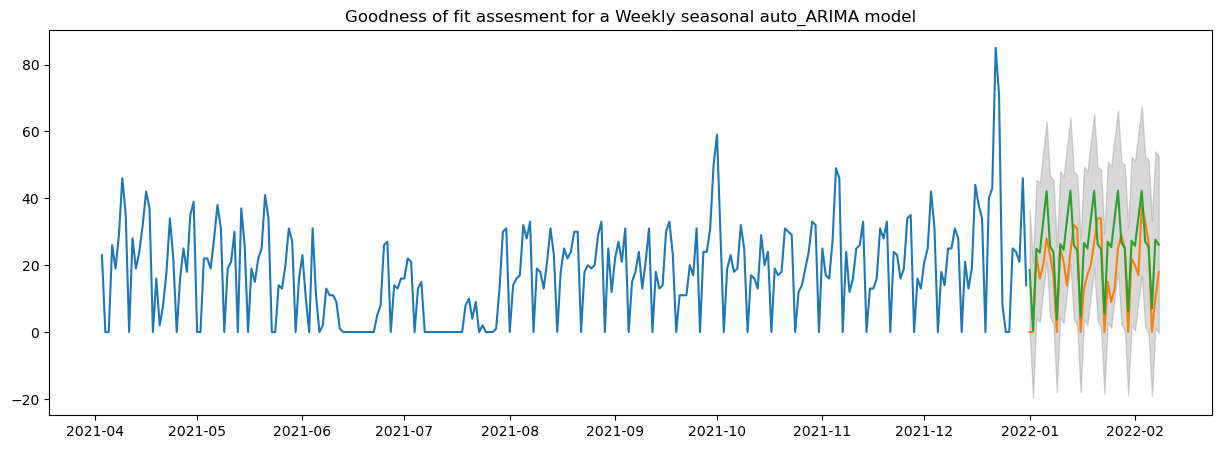

In [17]:
cf= pd.DataFrame(confint)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(itemTrain_df.set_index('day').sales_quantity)
ax.plot(itemVal_df.set_index('day').sales_quantity)
ax.plot(itemVal_df.set_index('day').arima_w_pred)
ax.fill_between(itemVal_df.set_index('day').arima_w_pred.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

plt.title('Goodness of fit assesment for a Weekly seasonal auto_ARIMA model')

In [19]:
# check more sophisticated model validation error
mean_absolute_error(itemVal_df.sales_quantity, itemVal_df.arima_w_pred)

8.97213629599655

In [24]:
def train_item_model(item_sales):
    weekly_model = auto_arima(item_sales.set_index('day').sales_quantity,
                    start_p=1,
                    start_q=1,
                    max_p=3,
                    max_q=3, 
                    m=7,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='trace',  
                    suppress_warnings=True, 
                    stepwise=True)


    return weekly_model

# XGboost

We will make a small XGBoost model to account for more recent variations in the data. The basic approach is to used lagged variables here along with some date values.

The correlations look good bu time is up...

In [26]:
from FFlowUtils.features import median_filter, RMSLE, backshift_df, add_date_features
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

import warnings

In [27]:
train_df = df_sales[df_sales.split=='train']
val_df = df_sales[df_sales.split=='validation']

Before selecting the model, however, we need to establish the seasonality:

In [28]:
item_list = list(df_sales.item_name.unique())

for item in item_list:
    itemTrain_df = train_df[train_df.item_name==item]
    itemVal_df = val_df[val_df.item_name==item]
 
    itemTrain_df = backshift_df(itemTrain_df, ['sales_quantity'], 1, 8)
    itemTrain_df = add_date_features(itemTrain_df, 'day')
    
    
    itemVal_df = backshift_df(itemVal_df, ['sales_quantity'], 1, 8)
    itemVal_df = add_date_features(itemVal_df, 'day')

/home/jeronimo/Desktop/Freshflow_techChallenge/FreshFlowChallenge/FFlowUtils/FFlowUtils/features.py:108: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_dateFeatures['weekofyear'] = df_dateFeatures[date_col].dt.weekofyear
/home/jeronimo/Desktop/Freshflow_techChallenge/FreshFlowChallenge/FFlowUtils/FFlowUtils/features.py:108: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_dateFeatures['weekofyear'] = df_dateFeatures[date_col].dt.weekofyear
/home/jeronimo/Desktop/Freshflow_techChallenge/FreshFlowChallenge/FFlowUtils/FFlowUtils/features.py:108: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_dateFeatures['weekofyear'] = df_dateFeatures[date_col].dt.weekofyear
/home/jeronimo/Desktop/Freshflow_techChallenge/FreshFlowChallenge/FFlowUtils/FFlowUti

/tmp/ipykernel_46675/3799638524.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(itemTrain_df.corr())


<AxesSubplot: >

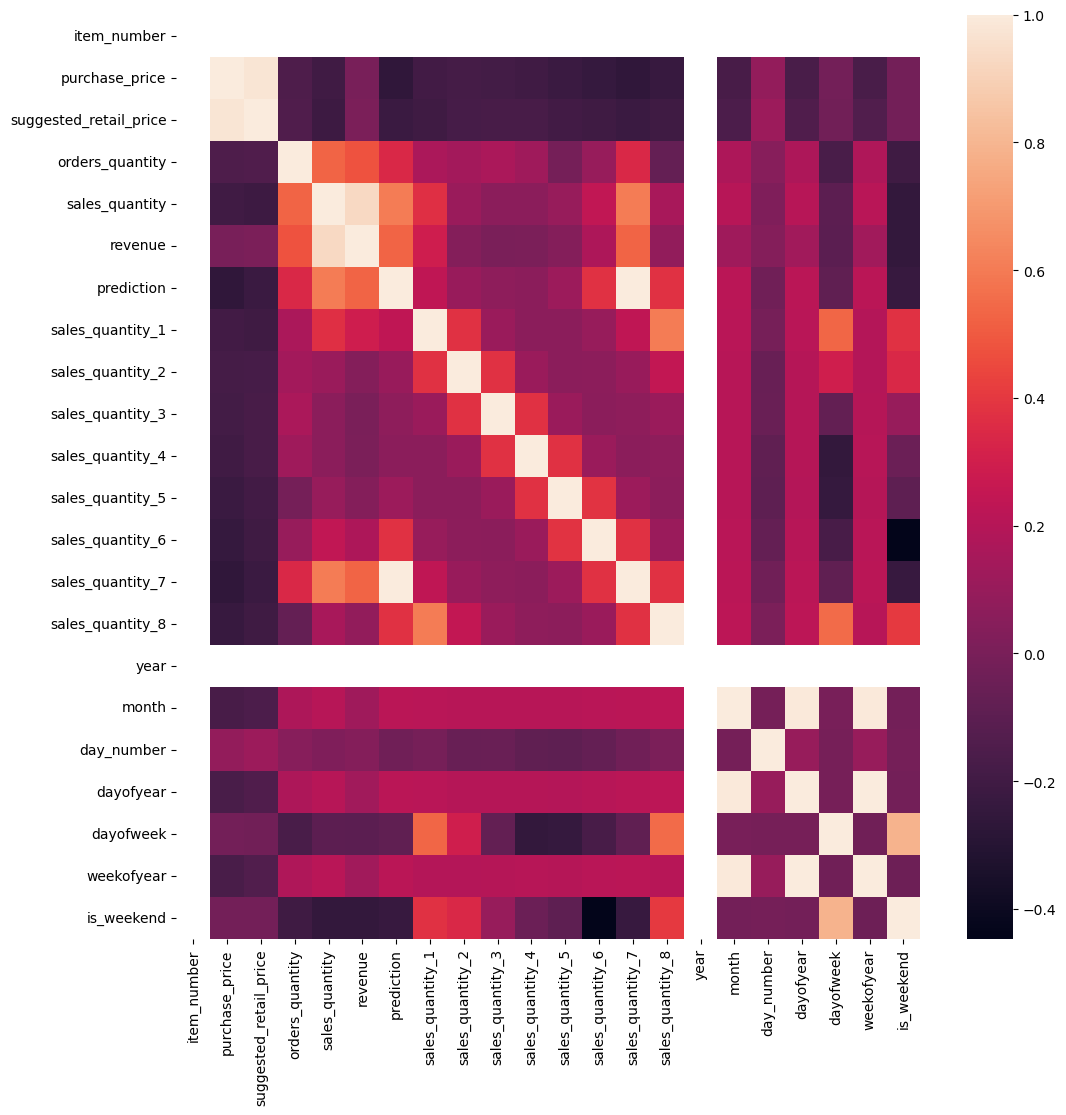

In [42]:
plt.figure(figsize=(12, 12))
sns.heatmap(itemTrain_df.corr())

In [29]:
itemTrain_df.columns

Index(['item_name', 'day', 'item_number', 'purchase_price',
       'suggested_retail_price', 'orders_quantity', 'sales_quantity',
       'revenue', 'split', 'prediction', 'sales_quantity_1',
       'sales_quantity_2', 'sales_quantity_3', 'sales_quantity_4',
       'sales_quantity_5', 'sales_quantity_6', 'sales_quantity_7',
       'sales_quantity_8', 'year', 'month', 'day_number', 'dayofyear',
       'dayofweek', 'weekofyear', 'is_weekend'],
      dtype='object')

In [30]:
itemTrain_df

,item_name,day,item_number,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,split,prediction,...,sales_quantity_6,sales_quantity_7,sales_quantity_8,year,month,day_number,dayofyear,dayofweek,weekofyear,is_weekend
626,UH ZWIEBELN DE-HE I 1KG GS,2021-04-03,80028349,0.674928,1.055314,0.0,23.0,22.77,train,NaN,...,NaN,NaN,NaN,2021,4,3,93,5,13,1
627,UH ZWIEBELN DE-HE I 1KG GS,2021-04-04,80028349,0.674928,1.055314,0.0,0.0,0.00,train,NaN,...,NaN,NaN,NaN,2021,4,4,94,6,13,1
628,UH ZWIEBELN DE-HE I 1KG GS,2021-04-05,80028349,0.674928,1.055314,0.0,0.0,0.00,train,NaN,...,NaN,NaN,NaN,2021,4,5,95,0,14,0
629,UH ZWIEBELN DE-HE I 1KG GS,2021-04-06,80028349,0.610000,0.790000,0.0,26.0,20.54,train,NaN,...,NaN,NaN,NaN,2021,4,6,96,1,14,0
630,UH ZWIEBELN DE-HE I 1KG GS,2021-04-07,80028349,0.610000,0.790000,0.0,19.0,15.01,train,NaN,...,NaN,NaN,NaN,2021,4,7,97,2,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,UH ZWIEBELN DE-HE I 1KG GS,2021-12-27,80028349,0.640000,0.990000,0.0,25.0,24.72,train,40.0,...,43.0,40.0,0.0,2021,12,27,361,0,52,0
895,UH ZWIEBELN DE-HE I 1KG GS,2021-12-28,80028349,0.640000,0.990000,0.0,24.0,23.64,train,43.0,...,85.0,43.0,40.0,2021,12,28,362,1,52,0
896,UH ZWIEBELN DE-HE I 1KG GS,2021-12-29,80028349,0.640000,0.990000,0.0,21.0,20.79,train,85.0,...,71.0,85.0,43.0,2021,12,29,363,2,52,0
897,UH ZWIEBELN DE-HE I 1KG GS,2021-12-30,80028349,0.640000,0.990000,0.0,46.0,45.40,train,71.0,...,8.0,71.0,85.0,2021,12,30,364,3,52,0


# Ensemble

Here the idea was to make an ensemble of the models which is likely to make for a better model.